In [15]:
# Import all necessary libraries for Task 4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

In [17]:
# -----------------------------------------------------------------------------
# Subtask 4.1: Prepare Data for Portfolio Optimization
# -----------------------------------------------------------------------------
# Load processed data for all assets from the data/processed directory
try:
    processed_data = pd.read_csv('../data/processed/all_assets_processed.csv', index_col=0, parse_dates=True)
    print("Processed data loaded successfully.")
except FileNotFoundError:
    print("Error: Processed data file not found. Please ensure Task 1 is completed.")
    exit()

# Load the future forecast for TSLA from Task 3
try:
    tsla_future_forecast = pd.read_csv('../outputs/results/tsla_lstm_future_forecast.csv', index_col=0, parse_dates=True).iloc[:, 0]
    print("TSLA future forecast loaded successfully.")
except FileNotFoundError:
    print("Warning: TSLA future forecast file not found. Please ensure Task 3 is completed.")
    tsla_future_forecast = None

# Calculate annualized expected returns for all assets using PyPortfolioOpt's method
mu = expected_returns.mean_historical_return(processed_data, frequency=252)

Processed data loaded successfully.
TSLA future forecast loaded successfully.


In [18]:
# If the forecast data exists, use it to override TSLA's historical expected return
if tsla_future_forecast is not None and not tsla_future_forecast.empty:
    # Calculate returns from the TSLA forecast
    tsla_forecast_returns = tsla_future_forecast.pct_change().dropna()
    # Annualize the forecast mean daily return for consistency
    mu['TSLA'] = tsla_forecast_returns.mean() * 252
else:
    print("Using historical mean return for TSLA.")

print("\nAnnualized Expected Returns:")
print(mu)


Annualized Expected Returns:
TSLA   -0.487442
BND     0.018311
SPY     0.136990
dtype: float64


In [19]:
# Calculate the annualized sample covariance matrix using historical daily returns
S = risk_models.sample_cov(processed_data, frequency=252)
print("\nAnnualized Covariance Matrix:")
print(S)


Annualized Covariance Matrix:
          TSLA       BND       SPY
TSLA  0.281823  0.001039  0.032636
BND   0.001039  0.002217  0.000367
SPY   0.032636  0.000367  0.019750


In [20]:
# Save the prepared data to the results directory
mu.to_csv('../outputs/results/expected_returns.csv', header=True)
S.to_csv('../outputs/results/covariance_matrix.csv', header=True)
print("Expected returns and covariance matrix saved to outputs/results/")


Expected returns and covariance matrix saved to outputs/results/


In [22]:
# -----------------------------------------------------------------------------
# Subtask 4.2: Generate the Efficient Frontier
# -----------------------------------------------------------------------------
# Initialize the EfficientFrontier object with the calculated returns and covariance matrix
ef = EfficientFrontier(mu, S)

# Find the portfolio with the maximum Sharpe Ratio
ef_sharpe = EfficientFrontier(mu, S)
weights_sharpe = ef_sharpe.max_sharpe()
cleaned_weights_sharpe = ef_sharpe.clean_weights()
print("\nMaximum Sharpe Ratio Portfolio Weights:")
print(cleaned_weights_sharpe)
sharpe_perf = ef_sharpe.portfolio_performance(verbose=True)


Maximum Sharpe Ratio Portfolio Weights:
OrderedDict({'TSLA': 0.0, 'BND': 0.51182, 'SPY': 0.48818})
Expected annual return: 7.6%
Annual volatility: 7.4%
Sharpe Ratio: 1.03


In [23]:
# Find the portfolio with the minimum volatility
ef_min_vol = EfficientFrontier(mu, S)
weights_min_vol = ef_min_vol.min_volatility()
cleaned_weights_min_vol = ef_min_vol.clean_weights()
print("\nMinimum Volatility Portfolio Weights:")
print(cleaned_weights_min_vol)
min_vol_perf = ef_min_vol.portfolio_performance(verbose=True)


Minimum Volatility Portfolio Weights:
OrderedDict({'TSLA': 0.0, 'BND': 0.91289, 'SPY': 0.08711})
Expected annual return: 2.9%
Annual volatility: 4.5%
Sharpe Ratio: 0.63


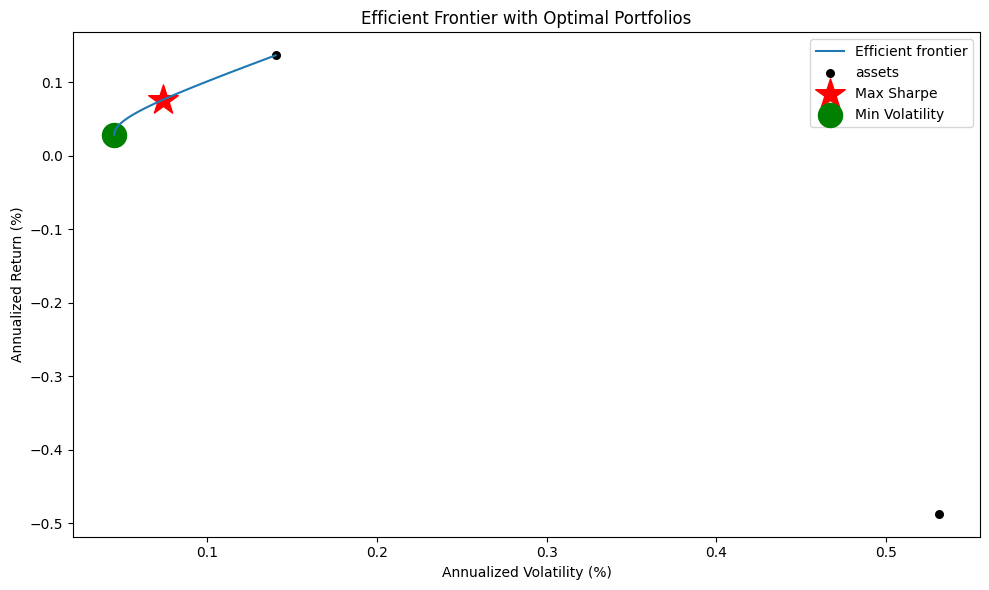

In [24]:
# Plot the Efficient Frontier with the optimal portfolios highlighted
fig, ax = plt.subplots(figsize=(10, 6))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
ret_sharpe, std_sharpe, _ = sharpe_perf
ax.scatter(std_sharpe, ret_sharpe, marker="*", s=500, c="r", label="Max Sharpe")
ret_min_vol, std_min_vol, _ = min_vol_perf
ax.scatter(std_min_vol, ret_min_vol, marker="o", s=300, c="g", label="Min Volatility")
ax.set_title("Efficient Frontier with Optimal Portfolios")
ax.set_xlabel("Annualized Volatility (%)")
ax.set_ylabel("Annualized Return (%)")
ax.legend()
plt.tight_layout()
plt.savefig('../outputs/plots/efficient_frontier.png')
plt.show()


In [25]:
# -----------------------------------------------------------------------------
# Subtask 4.3: Select and Recommend an Optimal Portfolio
# -----------------------------------------------------------------------------
# For this example, the Max Sharpe Ratio portfolio is recommended as it balances risk and reward.
recommended_portfolio_weights = cleaned_weights_sharpe
recommended_portfolio_performance = sharpe_perf

print("\n--- Portfolio Recommendation ---")
print("Based on the objective to optimize returns while managing risks, the **Maximum Sharpe Ratio Portfolio** is recommended.")
print("\n--- Recommended Portfolio Summary ---")
print("Optimal Weights:")


--- Portfolio Recommendation ---
Based on the objective to optimize returns while managing risks, the **Maximum Sharpe Ratio Portfolio** is recommended.

--- Recommended Portfolio Summary ---
Optimal Weights:


In [26]:
for asset, weight in recommended_portfolio_weights.items():
    print(f"  {asset}: {weight:.2%}")
print(f"\nExpected Annual Return: {recommended_portfolio_performance[0]:.2%}")
print(f"Annualized Volatility: {recommended_portfolio_performance[1]:.2%}")
print(f"Sharpe Ratio: {recommended_portfolio_performance[2]:.2f}")

  TSLA: 0.00%
  BND: 51.18%
  SPY: 48.82%

Expected Annual Return: 7.62%
Annualized Volatility: 7.40%
Sharpe Ratio: 1.03


In [27]:
# Save the optimal portfolio weights
pd.Series(recommended_portfolio_weights).to_csv('../outputs/results/recommended_portfolio_weights.csv', header=True)
print("Recommended portfolio weights saved to outputs/results/recommended_portfolio_weights.csv")

Recommended portfolio weights saved to outputs/results/recommended_portfolio_weights.csv
